<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

# Исследование для компании «Чётенькое такси»

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. 

Цель исследования это привлечение больше водителей в аэропорт в пик нагрузок.

Задача спрогнозировать количество заказов такси на следующий час.

*** 

Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
import warnings 
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.isna().sum()

num_orders    0
dtype: int64

## Анализ

In [6]:
monthly_stat = df.resample('1M').sum()
weekly_stat = df.resample('1W').sum()
hourly_stat = df.resample('1H').sum()

Text(0.5, 1.0, 'Статистика заказов в разбивке по месяцам')

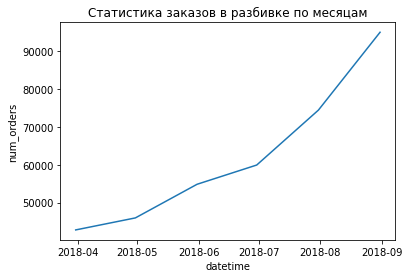

In [7]:
sns.lineplot(x=monthly_stat.index,y=monthly_stat['num_orders'])
plt.title('Статистика заказов в разбивке по месяцам')

Text(0.5, 1.0, 'Статистика заказов в разбивке по неделям')

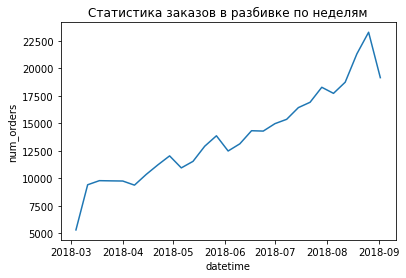

In [8]:
sns.lineplot(x=weekly_stat.index,y=weekly_stat['num_orders'])
plt.title('Статистика заказов в разбивке по неделям')

Text(0.5, 1.0, 'Статистика заказов в разбивке по часам')

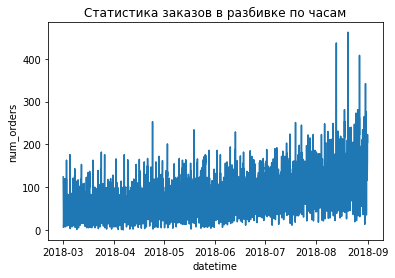

In [9]:
sns.lineplot(x=hourly_stat.index,y=hourly_stat['num_orders'])
plt.title('Статистика заказов в разбивке по часам')

In [10]:
df_copy = df.copy()
df_copy = df_copy.resample('1H').sum()
df_copy['rolling_mean'] = df_copy['num_orders'].shift().rolling(12).mean()
df_copy['std'] = df_copy['num_orders'].rolling(12).std()
df_copy = df_copy.dropna()

In [11]:
df_copy

,num_orders,rolling_mean,std
datetime,,,
2018-03-01 12:00:00,30,57.083333,29.997348
2018-03-01 13:00:00,32,49.250000,28.096695
2018-03-01 14:00:00,48,44.833333,26.908797
2018-03-01 15:00:00,66,42.916667,26.908797
2018-03-01 16:00:00,43,42.916667,26.908797
...,...,...,...
2018-08-31 19:00:00,136,163.416667,33.835050
2018-08-31 20:00:00,154,170.916667,33.966450
2018-08-31 21:00:00,159,168.583333,32.244685


In [12]:
decomposed = seasonal_decompose(df_copy['num_orders'])

Text(0.5, 1.0, 'Cкользящее среднее и скользящее стандартное отклонение')

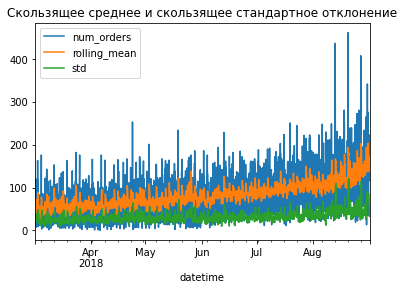

In [13]:
df_copy.plot()
plt.title('Cкользящее среднее и скользящее стандартное отклонение')

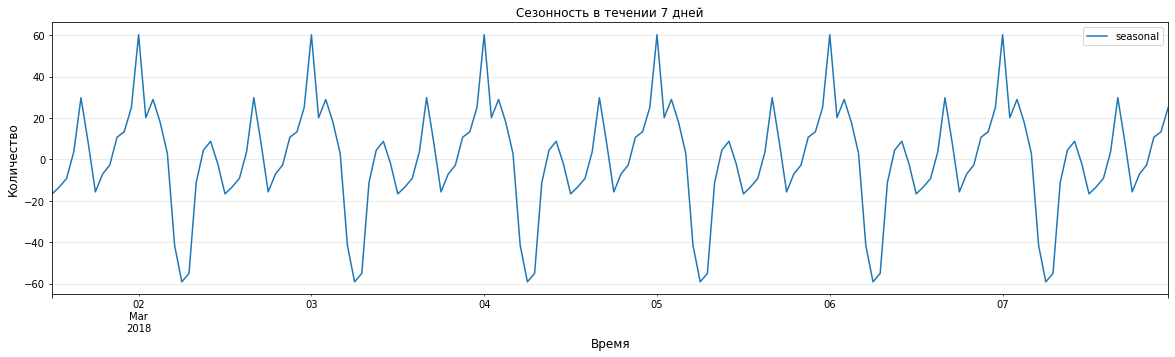

In [14]:
plt.figure(figsize=(20, 5))
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax=plt.gca())
plt.title('Сезонность в течении 7 дней')
plt.xlabel('Время', fontsize=12, color='black')
plt.ylabel('Количество', fontsize=12, color='black')
plt.grid(axis='y', alpha=.3)
plt.legend()
plt.show()

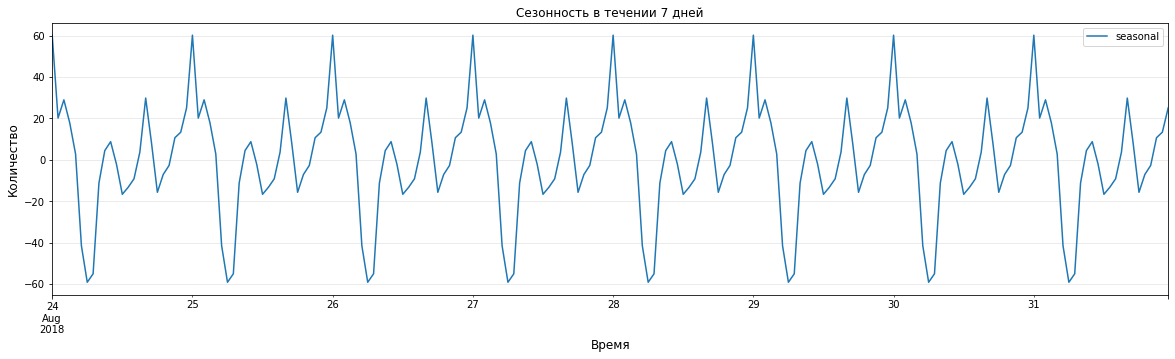

In [15]:
plt.figure(figsize=(20, 5))
decomposed.seasonal['2018-08-24':'2018-08-31'].plot(ax=plt.gca())
plt.title('Сезонность в течении 7 дней')
plt.xlabel('Время', fontsize=12, color='black')
plt.ylabel('Количество', fontsize=12, color='black')
plt.grid(axis='y', alpha=.3)
plt.legend()
plt.show()

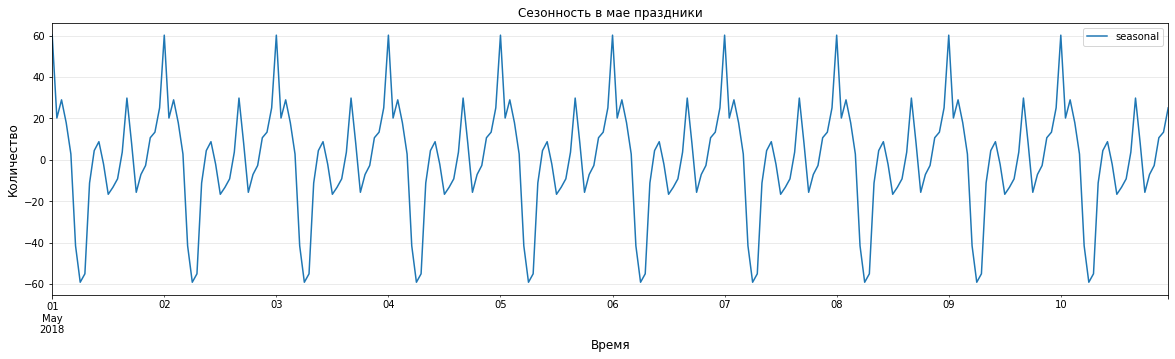

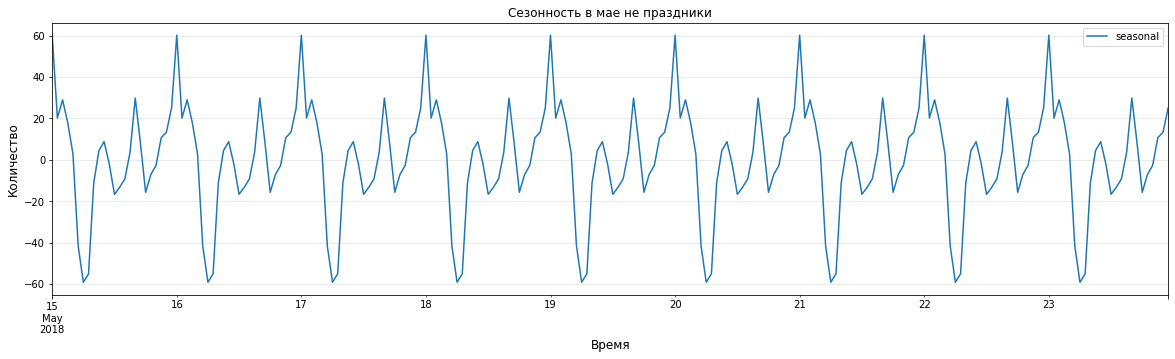

In [16]:
plt.figure(figsize=(20, 5))
decomposed.seasonal['2018-05-01':'2018-05-10'].plot(ax=plt.gca())
plt.title('Сезонность в мае праздники')
plt.xlabel('Время', fontsize=12, color='black')
plt.ylabel('Количество', fontsize=12, color='black')
plt.grid(axis='y', alpha=.3)
plt.legend()
plt.show()
plt.figure(figsize=(20, 5))
decomposed.seasonal['2018-05-15':'2018-05-23'].plot(ax=plt.gca())
plt.title('Сезонность в мае не праздники')
plt.xlabel('Время', fontsize=12, color='black')
plt.ylabel('Количество', fontsize=12, color='black')
plt.grid(axis='y', alpha=.3)
plt.legend()
plt.show()

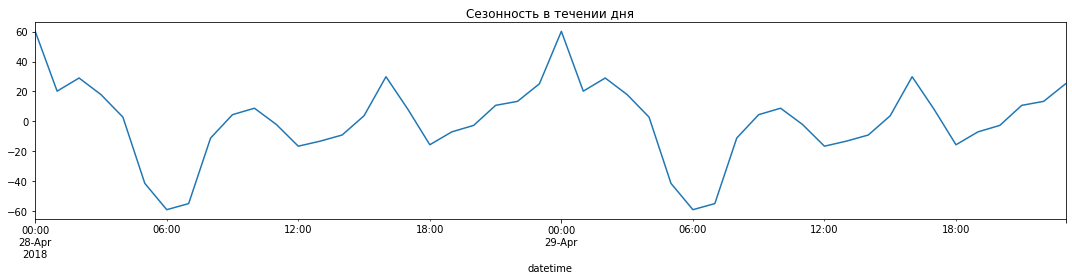

In [17]:
decomposed_df = seasonal_decompose(df_copy['num_orders'])
plt.figure(figsize=(15, 4))
decomposed_df.seasonal['2018-04-28':'2018-04-29'].plot(ax=plt.gca(), figsize=(15,4))
plt.title('Сезонность в течении дня')
plt.tight_layout()

In [18]:
%%time
ts = df['num_orders']
st_test = adfuller(ts, regression='ctt')

CPU times: user 10.8 s, sys: 12 s, total: 22.9 s
Wall time: 23.1 s


In [19]:
print('ADF Statistic: %f' % st_test[0])
print('p-value: %f' % st_test[1])
print('Critical Values:')
for key, value in st_test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -23.567848
p-value: 0.000000
Critical Values:
	1%: -4.372
	5%: -3.833
	10%: -3.553


Вот как интерпретировать наиболее важные значения в выводе:

   Значение ADF Statistic (-23.567848) меньше всех трех критических значений (-4.372, -3.833, -3.553) на уровне значимости 1%, 5% и 10%. Также, p-value (0.000000) меньше уровней значимости 1%, 5% и 10%. Это говорит о том, что мы можем отвергнуть нулевую гипотезу о наличии единичных корней в данных, и подтвердить альтернативную гипотезу о стационарности временного ряда. Таким образом, можно сделать вывод, что данный временной ряд является стационарным

***
Наибольшее количество заказов такси приходится на время с 17:00 до 00:00. В этот период спрос на услуги такси значительно превышает спрос в другие часы.
Нет различий в количестве заказов такси в разные месяцы. Количество заказов такси растет с марта по август. В 6 утра количество заказов такси наименьшее.

## Обучение

In [20]:
df = df.resample('1H').sum()

def make_features(data, max_lag, rolling_mean_size):
    #data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df, 9, 9)

In [21]:
df = df.dropna()

In [22]:
target = df['num_orders']
features = df.drop(['num_orders'], axis=1)

In [23]:
features_train, features_test, target_train, target_test = train_test_split(
    features.copy(), 
    target.copy(), 
    test_size=0.1, 
    shuffle=False)

In [24]:
print('Размер обучающей выборки: {} объектов, {} признаков'.format(features_train.shape[0], features_train.shape[1]))
print('Размер тестовой выборки: {} объектов, {} признаков'.format(features_test.shape[0], features_test.shape[1]))

Размер обучающей выборки: 3966 объектов, 11 признаков
Размер тестовой выборки: 441 объектов, 11 признаков


In [25]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [26]:
%%time

tscv = TimeSeriesSplit(n_splits=5)

params = {'n_neighbors': randint(1, 100),}

knn = KNeighborsClassifier()

random_search = RandomizedSearchCV(knn, param_distributions=params, n_iter=10, cv=tscv, random_state=42)

random_search.fit(features_train, target_train)

best_model = random_search.best_estimator_
predictions = best_model.predict(features_test)
rmse = np.sqrt(mean_squared_error(predictions, target_test))

print("Best hyperparameters: ", random_search.best_params_)
print("RMSE:", rmse)

Best hyperparameters:  {'n_neighbors': 93}
RMSE: 84.9439991594302
CPU times: user 2.58 s, sys: 72.8 ms, total: 2.65 s
Wall time: 2.66 s


In [27]:
%%time

tscv = TimeSeriesSplit(n_splits=5)

param_dist = {
"max_depth": randint(1, 15),
"min_samples_leaf": randint(1, 15),
"min_samples_split": randint(2, 25),
"max_features": ["auto", "sqrt", "log2"]
}

model = DecisionTreeRegressor()

random_search = RandomizedSearchCV(model, param_distributions=param_dist, cv=tscv, n_iter=20, random_state=42)
random_search.fit(features_train, target_train)

best_model = random_search.best_estimator_
predictions = best_model.predict(features_test)
rmse = np.sqrt(mean_squared_error(predictions, target_test))

print("Best hyperparameters: ", random_search.best_params_)
print("RMSE:", rmse)

Best hyperparameters:  {'max_depth': 9, 'max_features': 'auto', 'min_samples_leaf': 11, 'min_samples_split': 11}
RMSE: 48.50709853760001
CPU times: user 903 ms, sys: 21 ms, total: 924 ms
Wall time: 932 ms


In [28]:
%%time

tscv = TimeSeriesSplit(n_splits=5)

param_dist = {'n_estimators': randint(50, 150),'max_depth': randint(1, 10)}

model = lgb.LGBMRegressor()

random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=20, cv=tscv, random_state=42)
random_search.fit(features_train, target_train)

best_model = random_search.best_estimator_
predictions = best_model.predict(features_test)
rmse = np.sqrt(mean_squared_error(predictions, target_test))

print("Best hyperparameters: ", random_search.best_params_)
print("RMSE:", rmse)

Best hyperparameters:  {'max_depth': 9, 'n_estimators': 52}
RMSE: 46.003692067845215
CPU times: user 55.4 s, sys: 0 ns, total: 55.4 s
Wall time: 55.7 s


In [29]:
%%time

tscv = TimeSeriesSplit(n_splits=5)

param_dist = {"fit_intercept": [True, False], "normalize": [True, False], "n_jobs": [ 1, 1, 15]}

model = LinearRegression()

random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=20,cv=tscv, random_state=42)
random_search.fit(features_train, target_train)

best_model = random_search.best_estimator_
predictions = best_model.predict(features_test)
rmse = np.sqrt(mean_squared_error(predictions, target_test))

print("Best hyperparameters: ", random_search.best_params_)
print("RMSE:", rmse)

Best hyperparameters:  {'normalize': False, 'n_jobs': 1, 'fit_intercept': True}
RMSE: 54.137857741259985
CPU times: user 906 ms, sys: 93.3 ms, total: 999 ms
Wall time: 998 ms


In [30]:
%%time

tscv = TimeSeriesSplit(n_splits=5)

param_dist = {
"n_estimators": randint(50, 100),
"min_samples_split": randint(2, 11)}

model = RandomForestClassifier()

random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=20, cv=tscv, random_state=42)
random_search.fit(features_train, target_train)

best_model = random_search.best_estimator_
predictions = best_model.predict(features_test)
rmse = np.sqrt(mean_squared_error(predictions, target_test))

print("Best hyperparameters: ", random_search.best_params_)
print("RMSE:", rmse)

Best hyperparameters:  {'min_samples_split': 6, 'n_estimators': 82}
RMSE: 55.31144555216664
CPU times: user 1min 58s, sys: 3.22 s, total: 2min 1s
Wall time: 2min 1s


In [31]:
%%time

tscv = TimeSeriesSplit(n_splits=5)

param_dist = {
"max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10],
"min_samples_split": randint(2, 20)}

model = DecisionTreeRegressor()

random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=20, cv=tscv, random_state=42)
random_search.fit(features_train, target_train)

best_model = random_search.best_estimator_
predictions = best_model.predict(features_test)
rmse = np.sqrt(mean_squared_error(predictions, target_test))

print("Best hyperparameters: ", random_search.best_params_)
print("RMSE:", rmse)

Best hyperparameters:  {'max_depth': 9, 'min_samples_split': 13}
RMSE: 53.721085591206936
CPU times: user 1.33 s, sys: 16.3 ms, total: 1.34 s
Wall time: 1.35 s


In [32]:
%%time

tscv = TimeSeriesSplit(n_splits=5)

param_dist = {"learning_rate": [0.1]}

model = CatBoostRegressor()

random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=20, cv=tscv, random_state=42)
random_search.fit(features_train, target_train, verbose=False)

best_model = random_search.best_estimator_
predictions = best_model.predict(features_test)
rmse = np.sqrt(mean_squared_error(predictions, target_test))

print("Best hyperparameters: ", random_search.best_params_)
print("RMSE:", rmse)

Best hyperparameters:  {'learning_rate': 0.1}
RMSE: 46.49394867025971
CPU times: user 13 s, sys: 615 ms, total: 13.6 s
Wall time: 17.6 s


In [33]:
print(tscv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)


***

## Тестирование

In [34]:
modelCBR =CatBoostRegressor(learning_rate = 0.1)
modelCBR.fit(features_test, target_test, verbose=False)
modelCBR_predictions = modelCBR.predict(features_test)
print('CatBoostRegressor', np.sqrt(mean_squared_error(modelCBR_predictions, target_test)))

CatBoostRegressor 0.45200071676575404


In [35]:
modelLGBMR = LGBMRegressor(max_depth = 8, n_estimators = 73)
modelLGBMR.fit(features_test, target_test, verbose=False)
modelLGBMR_predictions = modelLGBMR.predict(features_test)
print('LGBMR', np.sqrt(mean_squared_error(modelLGBMR_predictions, target_test)))

LGBMR 20.405253249468927


<AxesSubplot:xlabel='datetime'>

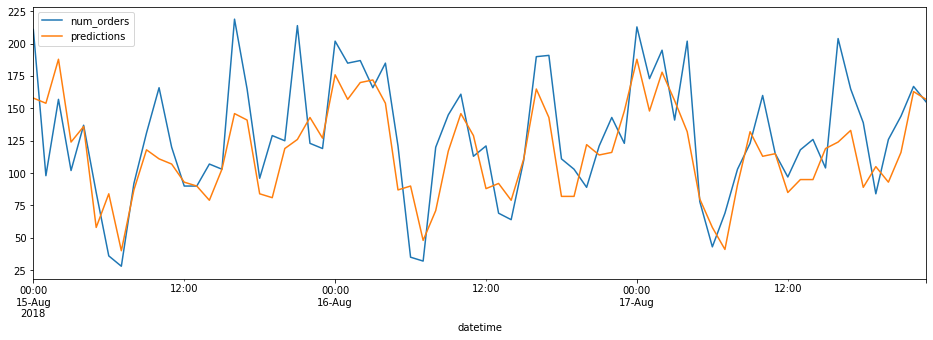

In [36]:
graph = target_test.copy()
predictions_taxi = pd.DataFrame(data = predictions, columns = ['predictions'], index = features_test.index.copy())
df_out = pd.merge(graph, predictions_taxi, how = 'left', left_index = True, right_index = True)
df_out['predictions'] = df_out['predictions'].astype('int64')
df_out['2018-08-15':'2018-08-17'].plot(figsize=(16,5))

ВЫВОД

На основе проведенного исследования можно сделать следующие выводы:

Наиболее оптимальным алгоритмом для прогнозирования количества заказов такси на следующий час оказался CatBoostRegressor с RMSE на тестовой выборке равным 0.45. Или LGBMR c RMSE 20.4

Было проведено ресемплирование данных с интервалом в один час, что позволило получить более точные прогнозы.
Временной ряд количества заказов такси является стационарным, что означает отсутствие трендов и сезонности в данных.

Наибольшее количество заказов такси приходится на время с 17:00 до 00:00, в этот период спрос на такси значительно превышает спрос в другие часы. Также было выявлено, что количество заказов такси растет с марта по август, а в 6 утра количество заказов наименьшее.

Для привлечения большего количества водителей в аэропорт в период пиковой нагрузки, можно использовать прогнозирование количества заказов такси на следующий час и, соответственно, предпринимать меры по привлечению водителей в тот период, когда ожидается наибольший спрос на такси.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48